# Proyek Klasifikasi Gambar: [Shoes Classification Dataset 13k images]
- **Nama:** [Hilman Fauzan]
- **Email:** [hilmanfauzan462@gmail.com]
- **ID Dicoding:** [hilmanfauzan]

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

#Library untuk visualisasi
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

# Library untuk pemrosesan data
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Library untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, Layer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

2025-05-03 11:52:03.643248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746273123.825352      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746273123.877264      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preparation

### Data Loading

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/TFRecords/Valid/Clog_1572.tfrecord
/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/TFRecords/Valid/Ballet Flat_82.tfrecord
/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/TFRecords/Valid/Sneaker_2242.tfrecord
/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/TFRecords/Valid/Sneaker_2041.tfrecord
/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/TFRecords/Valid/Sneaker_2467.tfrecord
/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/TFRecords/Valid/Sneaker_2260.tfrecord
/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/TFRecords/Valid/Clog_1568.tfrecord
/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/TFRecords/Valid/Boat_816.tfrecord
/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/TFRecords/Valid/Brogue_1080.tfrecord
/kaggle/input/shoes-classification-dataset-13k-images/S

**Pengecekan Resolusi Gambar**

In [ ]:
from PIL import Image
import os

def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        for img_file in [f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
                    total_images += 1
            except IOError:
                print(f"Skipping: {img_path} - Not a valid image file")

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

In [ ]:
print_images_resolution('/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/Train')
print_images_resolution('/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/Valid')

Dari hasil output diatas menunjukkan bahwa resolusi dari dataset bermacam-macam atau tidak segaram.

**Menggabungkan Data Train dan Data Validation ke Direktori yang Sama**

In [5]:
import os
import shutil


train_dir = "/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/Train/"
val_dir = "/kaggle/input/shoes-classification-dataset-13k-images/Shoes Dataset/Valid/"

combined_dir = "/kaggle/working/Dataset/Dataset_combined"


os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari validation
for category in os.listdir(val_dir):
    category_dir = os.path.join(val_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

**Memplot Gambar Sampel untuk Semua Kelas**

In [6]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "/kaggle/working/Dataset/"
path_sub = os.path.join(path, "Dataset_combined")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "/kaggle/working/Dataset/Dataset_combined"

# Menampilkan secara acak 6 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 6, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 6, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

**Memplot distribusi gambar di semua kelas**

Accessing data from: /kaggle/working/Dataset/Dataset_combined
Found 12500 files.
Example full path: ['/kaggle/working/Dataset/Dataset_combined/Boat/Boat Shoe-Valid (341).jpeg', '/kaggle/working/Dataset/Dataset_combined/Boat/Boat Shoe-Valid (119).jpeg', '/kaggle/working/Dataset/Dataset_combined/Boat/Boat Shoe-Train (1871).jpeg', '/kaggle/working/Dataset/Dataset_combined/Boat/Boat Shoe-Valid (474).jpeg', '/kaggle/working/Dataset/Dataset_combined/Boat/Boat Shoe-Valid (31).jpeg']...
Example labels: ['Boat', 'Boat', 'Boat', 'Boat', 'Boat']...

DataFrame created. First 5 rows:
                                                path  \
0  /kaggle/working/Dataset/Dataset_combined/Boat/...   
1  /kaggle/working/Dataset/Dataset_combined/Boat/...   
2  /kaggle/working/Dataset/Dataset_combined/Boat/...   
3  /kaggle/working/Dataset/Dataset_combined/Boat/...   
4  /kaggle/working/Dataset/Dataset_combined/Boat/...   

                     file_name labels  
0   Boat Shoe-Valid (341).jpeg   Boat  
1   B

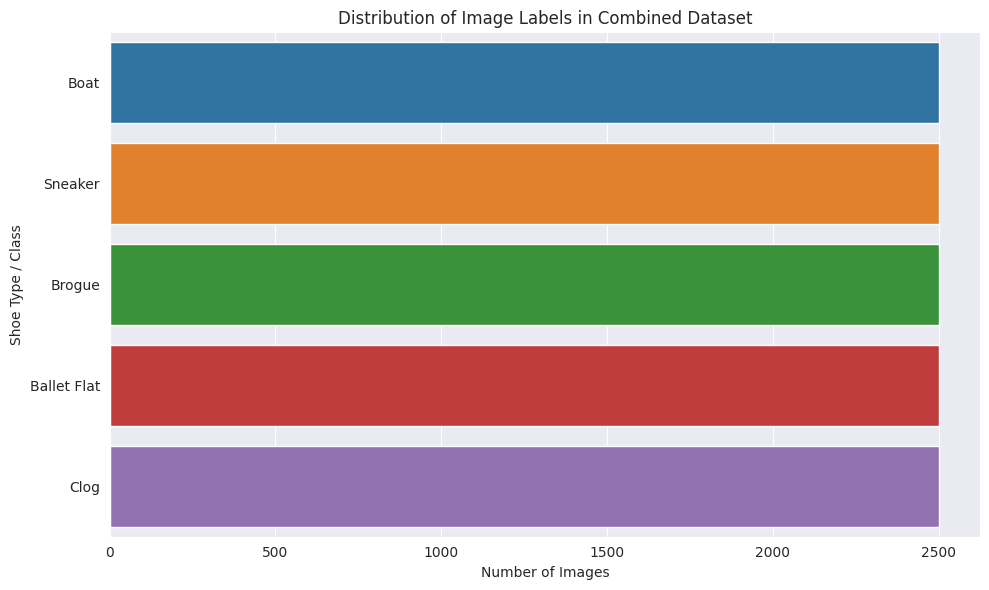

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns     


data_combined_path = "/kaggle/working/Dataset/Dataset_combined" 

file_name = []
labels = []
full_path = []

if not os.path.exists(data_combined_path):
    print(f"Error: Combined data directory not found at {data_combined_path}")
    print("Please ensure the unzip and combination steps were successful and the path is correct.")
else:
    print(f"Accessing data from: {data_combined_path}")

    # os.walk akan menjelajahi subfolder
    for path, subdirs, files in os.walk(data_combined_path):

        if path == data_combined_path:
             continue 
            
        label = path.split("/")[-1]
        
        # Loop melalui file di direktori kelas ini
        for name in files:
            item_full_path = os.path.join(path, name)
            if os.path.isfile(item_full_path):
                full_path.append(item_full_path)
                labels.append(label) 
                file_name.append(name)

    print(f"Found {len(full_path)} files.")
    if full_path: 
        print(f"Example full path: {full_path[:5]}...") 
        print(f"Example labels: {labels[:5]}...")  
    else:
        print("No files found in the combined directory.")


    # Membuat DataFrame Distribusi
    if full_path: 
        distribution_train = pd.DataFrame({"path":full_path, "file_name":file_name, "labels":labels})

        print("\nDataFrame created. First 5 rows:")
        print(distribution_train.head())

        # Cek distribusi jumlah file per label
        print("\nValue counts for labels:")
        print(distribution_train['labels'].value_counts())

        # --- Plot Distribusi Label ---
        print("\nGenerating count plot...")
        plt.figure(figsize = (10, 6)) 
        sns.set_style("darkgrid")

        plot_data = sns.countplot(y="labels", data=distribution_train, order=distribution_train["labels"].value_counts().index)

        plt.title('Distribution of Image Labels in Combined Dataset')
        plt.xlabel('Number of Images')
        plt.ylabel('Shoe Type / Class')
        plt.tight_layout() 
        plt.show() 


    else:
        print("\nDataFrame and plot were not created because no files were found.")

Dataset setiap kelas memiliki jumlah yang sama yang menunjukkan setiap kelas memiliki jumlah data yang seimbang.

### Data Preprocessing

#### Split Dataset

In [8]:
mypath = "/kaggle/working/Dataset/Dataset_combined"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
Ballet Flat    2500
Boat           2500
Brogue         2500
Clog           2500
Sneaker        2500
dtype: int64

**Membagi Dataset menjadi Data Train, Data Test, dan Data Validation**

In [9]:
# Menentukan pembagian dataset dengan rasio 70% untuk training, 15% untuk validation, dan 15% untuk testing
base_dir = "/kaggle/working/Dataset/Dataset_combined"
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [10]:
# Membuat direktori untuk data train, test, dan validation
os.makedirs('../data/train', exist_ok=True)
os.makedirs('../data/val', exist_ok=True)
os.makedirs('../data/test', exist_ok=True)

for class_name in os.listdir(base_dir):
    os.makedirs(os.path.join('../data/train', class_name), exist_ok=True)
    os.makedirs(os.path.join('../data/val', class_name), exist_ok=True)
    os.makedirs(os.path.join('../data/test', class_name), exist_ok=True)

In [11]:
# Membagi Dataset
for class_name in os.listdir(base_dir):
    source_dir = os.path.join(base_dir, class_name)
    all_files = os.listdir(source_dir)

    # Bagi data menjadi train dan sisa (val+test)
    train_files, remaining_files = train_test_split(all_files, train_size=train_ratio, random_state=42)

    # Bagi data sisa menjadi val dan test
    val_files, test_files = train_test_split(remaining_files, test_size=test_ratio/(val_ratio+test_ratio), random_state=42)

    # Pindahkan file ke direktori yang sesuai
    for file_name in train_files:
        shutil.copy(os.path.join(source_dir, file_name), os.path.join('../data/train', class_name, file_name))
    for file_name in val_files:
        shutil.copy(os.path.join(source_dir, file_name), os.path.join('../data/val', class_name, file_name))
    for file_name in test_files:
        shutil.copy(os.path.join(source_dir, file_name), os.path.join('../data/test', class_name, file_name))

In [12]:
# Menampilkan jumlah data setiap set
print("Jumlah data pada setiap set:")
print("-----------------------------")

# Menghitung jumlah data
train_count = sum([len(files) for r, d, files in os.walk("../data/train")])
test_count = sum([len(files) for r, d, files in os.walk("../data/test")])
val_count = sum([len(files) for r, d, files in os.walk("../data/val")])

print(f"Train: {train_count}")
print(f"Test: {test_count}")
print(f"Validation: {val_count}")

Jumlah data pada setiap set:
-----------------------------
Train: 8750
Test: 1875
Validation: 1875


Dataset dibagi menjadi 3 bagian data, yaitu data training dengan rasio 70%, data testing 15%, dan data validation sebesar 15%. Setelah dilakukan pembagian dataset, jumlah pada data train sebanyak 8.750 gambar, data testing sebanyak 1.875 gambar, dan pada data validation sebanyak 1.875 gambar.

In [13]:
lung_path = "/kaggle/working/Dataset/Dataset_combined"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

def get_dataset_summary(dataset_dir):
    summary = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        class_count = len(os.listdir(class_dir))
        summary[class_name] = class_count
    return summary

train_summary = get_dataset_summary('../data/train')
val_summary = get_dataset_summary('../data/val')
test_summary = get_dataset_summary('../data/test')

# Buat DataFrame kosong
df = pd.DataFrame(columns=['labels/kelas', 'train', 'val', 'test'])

# Tambahkan data ke DataFrame
for label in train_summary:
    df.loc[len(df)] = [label, train_summary[label], val_summary.get(label, 0), test_summary.get(label, 0)]

df.loc[len(df)] = ['Total', df['train'].sum(), df['val'].sum(), df['test'].sum()]

# Tampilkan DataFrame
print("=====================================================")
print(df)
print("=====================================================")

  labels/kelas  train   val  test
0      Sneaker   1750   375   375
1         Boat   1750   375   375
2         Clog   1750   375   375
3       Brogue   1750   375   375
4  Ballet Flat   1750   375   375
5        Total   8750  1875  1875


Pembagian data untuk setiap kelas pada bagian data train, masing-masing kelas memiliki jumlah gambar sebanyak 1.750 gambar. Pada data testing, masing-masing kelas memiliki jumlah sebanyak 375 gambar. Pada data validation, masing-masing kelas memiliki jumlah sebanyak 375 gambar.

In [14]:
datasource_path = "/kaggle/working/Dataset/Dataset_combined"
dataset_path = "/kaggle/working/Dataset/Dataset-shoes-Final/"

In [15]:
# Recreate the original DataFrame with the 'path' column
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(datasource_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

original_df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Iterate over the original DataFrame
for index, row in tq(original_df.iterrows()):
    # Deteksi filepath
    file_path = row['path']

    # Get the label from the path
    label = row['labels']

    # Create destination directory
    dest_dir = os.path.join(dataset_path, label)
    os.makedirs(dest_dir, exist_ok=True)

    # Copy the file
    shutil.copy2(file_path, dest_dir)

0it [00:00, ?it/s]

## Modelling

**Image Data Generator**

In [16]:
def get_dataset_summary(dataset_dir):
    summary = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        class_count = len(os.listdir(class_dir))
        summary[class_name] = class_count
    return summary

train_summary = get_dataset_summary('../data/train')
val_summary = get_dataset_summary('../data/val')
test_summary = get_dataset_summary('../data/test')

df = pd.DataFrame(columns=['labels/kelas', 'train', 'val', 'test'])


for label in train_summary:
    df.loc[len(df)] = [label, train_summary[label], val_summary.get(label, 0), test_summary.get(label, 0)]

df.loc[len(df)] = ['Total', df['train'].sum(), df['val'].sum(), df['test'].sum()]

print("=====================================================")
print(df.to_string())
print("=====================================================")

  labels/kelas  train   val  test
0      Sneaker   1750   375   375
1         Boat   1750   375   375
2         Clog   1750   375   375
3       Brogue   1750   375   375
4  Ballet Flat   1750   375   375
5        Total   8750  1875  1875


**Pembangunan Model**

In [17]:
# Direktori untuk menyimpan checkpoint model
CHECKPOINT_DIR = 'model_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

CHECKPOINT_PHASE1_PATH = os.path.join(CHECKPOINT_DIR, 'best_model_phase1.keras') 
CHECKPOINT_PHASE2_PATH = os.path.join(CHECKPOINT_DIR, 'best_model_phase2.keras') 

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=35,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    brightness_range=[0.7, 1.3],
    channel_shift_range=40.0,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data pelatihan
train_generator = train_datagen.flow_from_directory(
    '../data/train',
    batch_size=64,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True
)

# Generator untuk data validasi
validation_generator = test_datagen.flow_from_directory(
    '../data/val',
    batch_size=64,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

# Generator untuk data pengujian
test_generator = test_datagen.flow_from_directory(
    '../data/test',
    batch_size=64,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 8750 images belonging to 5 classes.
Found 1875 images belonging to 5 classes.
Found 1875 images belonging to 5 classes.


In [42]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import  ResNet101V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model = Sequential()

# Menggunakan ResNet101V2 dengan pretrained weights dari ImageNet
base_model =  ResNet101V2(include_top=False, weights='imagenet', input_shape=(150,150,3))

# Membekukan semua layer base model
base_model.trainable = False

# Menambahkan base model ke dalam model sequential
model.add(base_model)

# Menambahkan lapisan konvolusi (Conv2D)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D((2, 2))) 

# Menambahkan GlobalAveragePooling untuk meratakan output
model.add(GlobalAveragePooling2D())

# Menambahkan Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Menambahkan layer output untuk 5 kelas
model.add(Dense(5, activation='softmax'))

# Kompilasi model fase 1
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Ringkasan model
print("Model Summary setelah setting untuk Feature extraction")
model.summary()

Model Summary setelah setting untuk Feature extraction


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 5, 5, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 128)           │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,003,141 (171.67 MB)

 Trainable params: 2,376,581 (9.07 MB)

 Non-trainable params: 42,626,560 (162.61 MB)

**Implementasi Callback**

In [43]:
# Callbacks untuk early stopping, model checkpoint dan learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
checkpoint_callback_phase1 = ModelCheckpoint(filepath=CHECKPOINT_PHASE1_PATH, monitor="val_accuracy", save_best_only=True, mode="max")

# Menambahkan callbacks untuk pelatihan
callbacks_phase1 = [early_stopping, checkpoint_callback_phase1]

**Pelatihan Fase 1**

In [44]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks_phase1
)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 91s 483ms/step - accuracy: 0.4065 - loss: 1.8105 - val_accuracy: 0.6651 - val_loss: 0.9279
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 386ms/step - accuracy: 0.6139 - loss: 1.0581 - val_accuracy: 0.6896 - val_loss: 0.8647
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 387ms/step - accuracy: 0.6567 - loss: 0.9302 - val_accuracy: 0.6955 - val_loss: 0.8163
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 387ms/step - accuracy: 0.6702 - loss: 0.8862 - val_accuracy: 0.7131 - val_loss: 0.7916
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 387ms/step - accuracy: 0.6905 - loss: 0.8488 - val_accuracy: 0.7173 - val_loss: 0.7670
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 389ms/step - accuracy: 0.6991 - loss: 0.8107 - val_accuracy: 0.7344 - val_loss: 0.7474
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 54s 376ms/step - accuracy: 0.7196 - loss: 0.7917 - val_accuracy: 0.7275 - val_loss: 0.7437
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 55s 384ms/step - accuracy: 0.7171 - loss: 0

In [45]:
# Simpan history dari fase 1 ke variabel baru
history_phase1 = history

**Implementasi Fine-Tuning (Fase 2)**

In [78]:
print(f"\n--- Memulai pengaturan fase fine-tuning ---")

# Muat bobot terbaik dari Fase 1
if os.path.exists(CHECKPOINT_PHASE1_PATH):
    print(f"Memuat bobot terbaik dari fase 1: {CHECKPOINT_PHASE1_PATH}")
    model.load_weights(CHECKPOINT_PHASE1_PATH)
    print("Bobot terbaik.")
else:
    print(f"Warning: Phase 1 checkpoint not found at {CHECKPOINT_PHASE1_PATH}.")
    print("Fine-tuning will start from the last state of the model after Phase 1 attempt (or initial state if Phase 1 skipped).")

unfreeze_from_layer_index = 60
print(f"Unfreezing base model layers from index {unfreeze_from_layer_index} onwards.")

base_model.trainable = True

#Membekukan kembali layer
for i, layer in enumerate(base_model.layers):
    if i < unfreeze_from_layer_index or isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Cek kembali status trainable setiap layer di base_model
print("\nBase Model Layer Trainable Status after partial unfreezing:")
layer_indices_to_print = list(range(unfreeze_from_layer_index - 5, unfreeze_from_layer_index + 5)) + [0, len(base_model.layers)-1]
layer_indices_to_print = sorted(list(set([i for i in layer_indices_to_print if 0 <= i < len(base_model.layers)])))
for i in layer_indices_to_print:
    layer = base_model.layers[i]
    print(f"Layer {i}: {layer.name} is trainable: {layer.trainable}")

# Kompilasi ulang model setelah unfreeze
fine_tune_learning_rate = 6e-6

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=fine_tune_learning_rate),
              metrics=['accuracy'])

print(f"\nModel dikompilasi ulang untuk Fine-Tuning dengan learning rate: {fine_tune_learning_rate}")
print("Model Summary (Fine-Tuning - Partially Unfrozen Base Model):")
model.summary()


--- Memulai pengaturan fase fine-tuning ---
Memuat bobot terbaik dari fase 1: model_checkpoints/best_model_phase1.keras
Bobot terbaik.
Unfreezing base model layers from index 60 onwards.

Base Model Layer Trainable Status after partial unfreezing:
Layer 0: input_layer_3 is trainable: False
Layer 55: conv3_block2_1_bn is trainable: False
Layer 56: conv3_block2_1_relu is trainable: False
Layer 57: conv3_block2_2_pad is trainable: False
Layer 58: conv3_block2_2_conv is trainable: False
Layer 59: conv3_block2_2_bn is trainable: False
Layer 60: conv3_block2_2_relu is trainable: False
Layer 61: conv3_block2_3_conv is trainable: False
Layer 62: conv3_block2_out is trainable: False
Layer 63: conv3_block3_preact_bn is trainable: False
Layer 64: conv3_block3_preact_relu is trainable: False
Layer 376: post_relu is trainable: True

Model dikompilasi ulang untuk Fine-Tuning dengan learning rate: 6e-06
Model Summary (Fine-Tuning - Partially Unfrozen Base Model):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)             │ (None, 5, 5, 2048)          │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 128)           │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,003,141 (171.67 MB)

 Trainable params: 41,859,973 (159.68 MB)

 Non-trainable params: 3,143,168 (11.99 MB)

In [79]:
# Callbacks untuk early stopping, model checkpoint dan learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
checkpoint_callback_phase2 = ModelCheckpoint(filepath=CHECKPOINT_PHASE2_PATH, monitor="val_accuracy", save_best_only=True, mode="max")


callbacks_phase2 = [early_stopping, checkpoint_callback_phase2]

In [80]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks_phase2
)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 119s 532ms/step - accuracy: 0.8644 - loss: 0.3939 - val_accuracy: 0.8053 - val_loss: 0.6302
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 409ms/step - accuracy: 0.8727 - loss: 0.3601 - val_accuracy: 0.8144 - val_loss: 0.6029
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 411ms/step - accuracy: 0.8857 - loss: 0.3306 - val_accuracy: 0.8240 - val_loss: 0.6162
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 392ms/step - accuracy: 0.8939 - loss: 0.3020 - val_accuracy: 0.8197 - val_loss: 0.5953
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 411ms/step - accuracy: 0.9001 - loss: 0.2928 - val_accuracy: 0.8256 - val_loss: 0.5886
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 58s 404ms/step - accuracy: 0.9021 - loss: 0.2844 - val_accuracy: 0.8272 - val_loss: 0.5940
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 386ms/step - accuracy: 0.9018 - loss: 0.2911 - val_accuracy: 0.8251 - val_loss: 0.5965
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 58s 405ms/step - accuracy: 0.9136 - loss: 

## Evaluasi dan Visualisasi

**Evaluasi Model**

In [81]:
# Evaluasi model menggunakan data training
loss, accuracy = model.evaluate(train_generator, verbose=2)
print("Akurasi pada data training: {:.4f} ({:.2f}%)".format(accuracy, accuracy * 100))
print("Loss pada data training:", loss)

# Evaluasi model menggunakan data testing
loss, accuracy = model.evaluate(test_generator, verbose=2)
print("Akurasi pada data testing: {:.4f} ({:.2f}%)".format(accuracy, accuracy * 100))
print("Loss pada data testing:", loss)


137/137 - 53s - 390ms/step - accuracy: 0.9365 - loss: 0.1897
Akurasi pada data training: 0.9365 (93.65%)
Loss pada data training: 0.1896577924489975
30/30 - 2s - 75ms/step - accuracy: 0.8555 - loss: 0.5197
Akurasi pada data testing: 0.8555 (85.55%)
Loss pada data testing: 0.5196592807769775


**Visualisasi Accuracy**

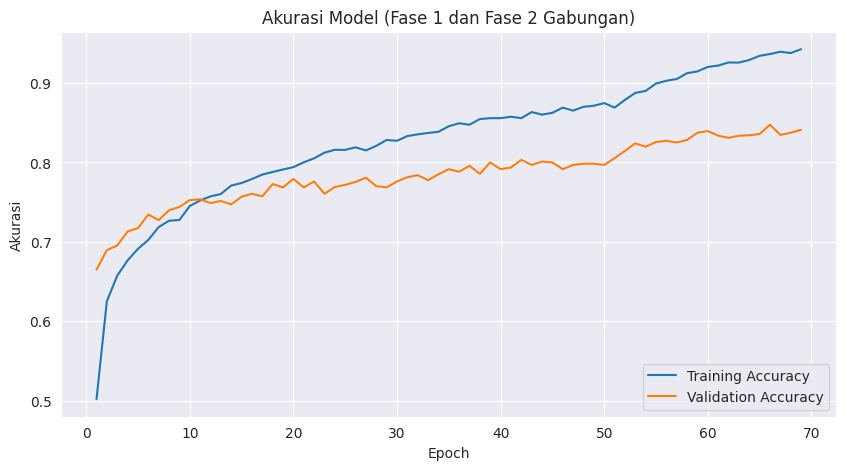

In [82]:
# Gabungkan data history dari fase 1 dan fase 2
epochs_phase1 = len(history_phase1.history['accuracy'])
epochs_phase2 = len(history.history['accuracy'])
total_epochs = epochs_phase1 + epochs_phase2

# Buat array epoch gabungan
epochs = np.arange(1, total_epochs + 1)

# Gabungkan data akurasi
accuracy_train = history_phase1.history['accuracy'] + history.history['accuracy']
accuracy_val = history_phase1.history['val_accuracy'] + history.history['val_accuracy']

# Plot akurasi gabungan
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_train, label="Training Accuracy")
plt.plot(epochs, accuracy_val, label="Validation Accuracy")
plt.title('Akurasi Model (Fase 1 dan Fase 2 Gabungan)')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

**Visualisasi Loss**

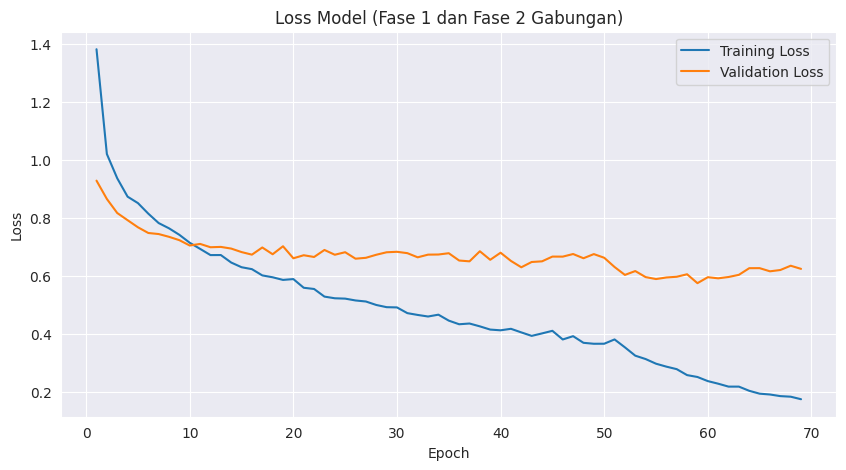

In [83]:
# Gabungkan data history dari fase 1 dan fase 2
epochs_phase1 = len(history_phase1.history['loss'])  
epochs_phase2 = len(history.history['loss'])  
total_epochs = epochs_phase1 + epochs_phase2

# Buat array epoch gabungan
epochs = np.arange(1, total_epochs + 1)

# Gabungkan data loss
loss_train = history_phase1.history['loss'] + history.history['loss']
loss_val = history_phase1.history['val_loss'] + history.history['val_loss']

# Plot loss gabungan
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_train, label="Training Loss")
plt.plot(epochs, loss_val, label="Validation Loss")
plt.title('Loss Model (Fase 1 dan Fase 2 Gabungan)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right') 
plt.show()

**Report Klasifikasi**

In [84]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

# Tampilkan laporan klasifikasi
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step
              precision    recall  f1-score   support

 Ballet Flat       0.88      0.88      0.88       375
        Boat       0.81      0.81      0.81       375
      Brogue       0.86      0.90      0.88       375
        Clog       0.86      0.80      0.83       375
     Sneaker       0.86      0.89      0.88       375

    accuracy                           0.86      1875
   macro avg       0.86      0.86      0.86      1875
weighted avg       0.86      0.86      0.86      1875



**Confusion Matrix**

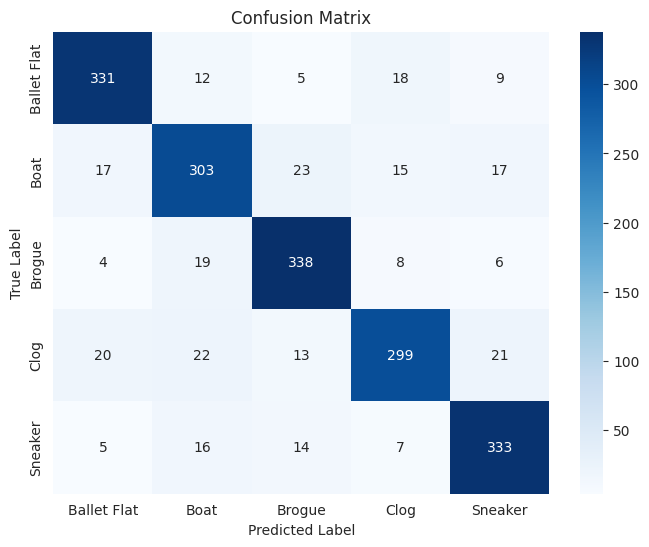

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

# Buat label kelas
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Konversi Model

In [86]:
import os
import tensorflow as tf
import tensorflowjs as tfjs
from IPython.display import FileLink, display

In [87]:
# Mendefinisikan direktori output
output_base_dir = 'submission'
tfjs_output_dir = os.path.join(output_base_dir, 'tfjs_model')
tflite_output_dir = os.path.join(output_base_dir, 'tflite')
saved_model_output_dir = os.path.join(output_base_dir, 'saved_model_tf') 

os.makedirs(tfjs_output_dir, exist_ok=True)
os.makedirs(tflite_output_dir, exist_ok=True)
os.makedirs(saved_model_output_dir, exist_ok=True)

**Konversi Model ke Format SavedModel**

In [88]:
print("Memulai proses konversi model")

keras_temp_save_path = 'temp_keras_model.keras' 
try:
    # Simpan model Keras ke file
    model.save(keras_temp_save_path)
    print(f"Model Keras berhasil disimpan sementara ke {keras_temp_save_path}")

    loaded_model = tf.keras.models.load_model(keras_temp_save_path)
    print("Model Keras berhasil dimuat kembali.")

except Exception as e:
    print(f"Peringatan: Gagal menyimpan/memuat model Keras: {e}. Menggunakan objek model asli.")
    loaded_model = model 

# Konversi ke format SavedModel
try:
    tf.saved_model.save(model, saved_model_output_dir)
    print(f"Konversi SavedModel selesai. Output: {saved_model_output_dir}")
except Exception as e:
    print(f"Error selama konversi SavedModel: {e}")


Memulai proses konversi model
Model Keras berhasil disimpan sementara ke temp_keras_model.keras
Model Keras berhasil dimuat kembali.
Konversi SavedModel selesai. Output: submission/saved_model_tf


**Konversi Model ke dalam Format TF-Lite**

In [89]:
# Konversi ke format TF-Lite
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model) 
    tflite_model = converter.convert()
    tflite_output_path = os.path.join(tflite_output_dir, 'model.tflite')
    with open(tflite_output_path, 'wb') as f:
        f.write(tflite_model)

    # Simpan file label 
    label_output_path = os.path.join(tflite_output_dir, 'label.txt')
    with open(label_output_path, 'w') as f:

        f.write('Boots\nSandals\nSlippers\nSneakers\nFormal Shoes')
    print(f"Konversi TF-Lite selesai. Output: {tflite_output_path} dan {label_output_path}")

except Exception as e:
    print(f"Error selama konversi TF-Lite: {e}")

Saved artifact at '/tmp/tmpv_qjvtwz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132998140526864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132998140528592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132997723676432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132997723682384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132998140530128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132997723682576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132997723678928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132997723679696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132997723679888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132997723679504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1329977236779

W0000 00:00:1746297480.567847      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746297480.567896      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Konversi TF-Lite selesai. Output: submission/tflite/model.tflite dan submission/tflite/label.txt


**Konversi Model ke dalam Format TFJS**

In [90]:
# Konversi ke format TFJS 
try:
    tfjs_output_dir = os.path.join(output_base_dir, 'tfjs_model')
    tfjs.converters.save_keras_model(loaded_model, tfjs_output_dir) 
    print(f"Konversi TFJS selesai. Output: {tfjs_output_dir}")
except Exception as e:
    print(f"Error selama konversi TFJS: {e}")

failed to lookup keras version from the file,
    this is likely a weight only file
Konversi TFJS selesai. Output: submission/tfjs_model


In [91]:
# Membuat file zip dan mendownload file zip submission
print("Membuat file zip dari folder submission")
try:
    # Zip direktori utama submission
    !zip -r {output_base_dir}.zip {output_base_dir}/
    print(f"File zip {output_base_dir}.zip berhasil dibuat.")
    display(FileLink(f'{output_base_dir}.zip'))
except Exception as e:
    print(f"Error saat membuat file zip atau FileLink: {e}")

print("Proses konversi selesai.")

Membuat file zip dari folder submission
updating: submission/ (stored 0%)
updating: submission/saved_model_tf/ (stored 0%)
updating: submission/saved_model_tf/saved_model.pb (deflated 93%)
updating: submission/saved_model_tf/fingerprint.pb (stored 0%)
updating: submission/saved_model_tf/variables/ (stored 0%)
updating: submission/saved_model_tf/variables/variables.index (deflated 81%)
updating: submission/saved_model_tf/variables/variables.data-00000-of-00001 (deflated 8%)
updating: submission/saved_model_tf/assets/ (stored 0%)
updating: submission/tflite/ (stored 0%)
updating: submission/tflite/label.txt (deflated 7%)
updating: submission/tflite/model.tflite (deflated 7%)
updating: submission/tfjs_model/ (stored 0%)
updating: submission/tfjs_model/group1-shard9of41.bin (deflated 7%)
updating: submission/tfjs_model/group1-shard40of41.bin (deflated 6%)
updating: submission/tfjs_model/group1-shard18of41.bin (deflated 7%)
updating: submission/tfjs_model/group1-shard1of41.bin (deflated 7%)

/kaggle/working/submission.zip

Proses konversi selesai.


## Inference (Optional)